## Defining the Model to use

In [1]:
import os
import json
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "langgraph-Basic-code-Reviewer"

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langsmith import traceable

# llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
llm = ChatGroq(model="qwen-2.5-coder-32b", temperature=0.7)

## Defining the tools

## Binding the tools

## Define the Initial State

In [2]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph, END

from langgraph.checkpoint.memory import MemorySaver
# from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display


In [3]:
class ExtendedMessagesState(TypedDict):
    """Extended state definition for LangGraph to ensure all keys persist."""
    messages: List[AnyMessage]  # Store messages
    code: str  
    code_segments: str
    test_cases: str
    test_results: str
    feedback: str
    ai_feedback: str
    improved_code: str

## Defining the graph

#### First I define a node that will be helpful for the human feedback

In [4]:
def receive_code(state: ExtendedMessagesState):
    """Receive the user code and store it in the state."""
    if "messages" not in state or not state["messages"]:
        raise ValueError("No messages found in the state.")
    code = state["messages"][-1].content    
    return {**state, "code": code}

@traceable
def code_segmentation(state: ExtendedMessagesState):
    """ Analyze the code,split it in sections so that later you can produce test cases for each section""" 

    if "code" not in state:
        raise KeyError("'code' is missing from state. Ensure you are providing the code first.")
    
    code = state["code"]
    prompt = f"""
    Analyze the code,split it in sections so that later you can produce test cases for each section    
    {code}    
    """
    code_segments = llm.invoke(prompt).content
    return {**state, "code_segments": code_segments}   

In [5]:
@traceable
def produce_test_cases(state: ExtendedMessagesState):
    """ Produce test cases for each section of the code you have previously produced"""
    code_segments = state["code_segments"]
    prompt = f"""Produce test cases for each section of the code you have previously produced:{code_segments}"""
    test_cases = llm.invoke(prompt).content
    return {**state, "test_cases": test_cases}

In [6]:
@traceable
def human_feedback_add_test(state: ExtendedMessagesState):
    # """ Define the state variable feedback by using the last Human message"""
    # feedback = state["messages"][-1].content  
    # print("\n\n Feedback\n\n",feedback)
    # input()
    # return {**state, "feedback":state.get("feedback",None)}
    """ No-op node that should be interrupted on """
    pass

In [7]:
def custom_condition(state: ExtendedMessagesState):
    """Custom condition to check if the user has provided feedback and added test cases"""    
    human_feedback= state["feedback"]
    print("\n\n",human_feedback)
    input()
    if "code_segmentation" in human_feedback:
        return "code_segmentation"
    elif "produce_test_cases" in human_feedback:
        return "produce_test_cases"
    else:
        return "run_tests"

In [8]:
@traceable
def run_tests(state: ExtendedMessagesState):
    """ Once all test cases are produced and added, run the tests"""
    test_cases = state["test_cases"]
    prompt = f"""Run the tests:{test_cases}"""
    test_results = llm.invoke(prompt).content
    return {**state, "test_results": test_results}

In [9]:
@traceable
def analyze_failed_test(state: ExtendedMessagesState):
    """ Analyze the failed tests and provide feedback"""
    test_results = state["test_results"]
    prompt = f"""Analyze the failed tests and provide feedback:{test_results}"""
    ai_feedback = llm.invoke(prompt).content
    return {**state, "ai_feedback": ai_feedback}

In [10]:
@traceable
def improve_code(state: ExtendedMessagesState):
    """ Improve the code based on test results"""
    test_results = state["test_results"]
    prompt = f"""Improve the code based on test results:{test_results}"""
    improved_code = llm.invoke(prompt).content
    return {**state, "improved_code": improved_code}

#### Then I define the graph

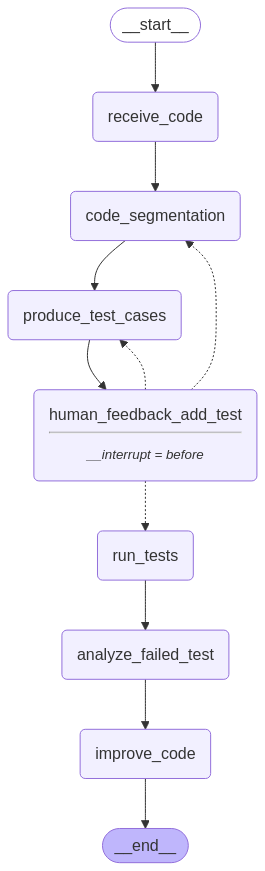

In [11]:
builder = StateGraph(MessagesState)

## Define the node
builder.add_node("receive_code",receive_code)
builder.add_node("code_segmentation",code_segmentation)
builder.add_node("produce_test_cases",produce_test_cases)
builder.add_node("human_feedback_add_test",human_feedback_add_test)
builder.add_node("run_tests",run_tests)
builder.add_node("analyze_failed_test",analyze_failed_test)
builder.add_node("improve_code",improve_code)
# Define edges
builder.add_edge(START,"receive_code")
builder.add_edge("receive_code","code_segmentation")
builder.add_edge("code_segmentation","produce_test_cases")
builder.add_edge("produce_test_cases","human_feedback_add_test")
builder.add_conditional_edges(
    "human_feedback_add_test", custom_condition, 
    {"code_segmentation":"code_segmentation",
    "produce_test_cases":"produce_test_cases",
     "run_tests": "run_tests"}
)
builder.add_edge("run_tests","analyze_failed_test")
builder.add_edge("analyze_failed_test","improve_code")
builder.add_edge("improve_code",END)

# Set up memory
memory = MemorySaver()
# Compile the graph with memory
codeReviewer = builder.compile(interrupt_before=["human_feedback_add_test"],checkpointer=memory)

# Show
display(Image(codeReviewer.get_graph().draw_mermaid_png()))

## Using the Agent

#### First call to use the Arxiv tool

#### Invoking the llm

In [12]:
# Input
# user_input=input("Provide the code for the model to analyze.")
user_input_code="""def divide(a, b):
                "Returns the division of two numbers, handling division by zero."
                if b == 0:
                    return "Error: Division by zero is not allowed."
                return a / b

            def congruence(a, b, mod):
                "Checks if two numbers are congruent modulo 'mod'."
                return (a - b) % mod == 0"""

messages = {"messages": [HumanMessage(content=user_input_code)]}
thread = {"configurable": {"thread_id": "initial_code"}}

for event in codeReviewer.stream(messages, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

def divide(a, b):
                "Returns the division of two numbers, handling division by zero."
                if b == 0:
                    return "Error: Division by zero is not allowed."
                return a / b

            def congruence(a, b, mod):
                "Checks if two numbers are congruent modulo 'mod'."
                return (a - b) % mod == 0
================================ Human Message =================================

def divide(a, b):
                "Returns the division of two numbers, handling division by zero."
                if b == 0:
                    return "Error: Division by zero is not allowed."
                return a / b

            def congruence(a, b, mod):
                "Checks if two numbers are congruent modulo 'mod'."
                return (a - b) % mod == 0
================================ Human Message =================================

def 

In [13]:
print(codeReviewer.get_state(thread).next)
print(codeReviewer.get_state(thread).values)

('human_feedback_add_test',)
{'messages': [HumanMessage(content='def divide(a, b):\n                "Returns the division of two numbers, handling division by zero."\n                if b == 0:\n                    return "Error: Division by zero is not allowed."\n                return a / b\n\n            def congruence(a, b, mod):\n                "Checks if two numbers are congruent modulo \'mod\'."\n                return (a - b) % mod == 0', additional_kwargs={}, response_metadata={}, id='4b52a87c-727b-45cf-bf51-97236717ebf9')], 'code': 'def divide(a, b):\n                "Returns the division of two numbers, handling division by zero."\n                if b == 0:\n                    return "Error: Division by zero is not allowed."\n                return a / b\n\n            def congruence(a, b, mod):\n                "Checks if two numbers are congruent modulo \'mod\'."\n                return (a - b) % mod == 0', 'code_segments': 'Certainly! Let\'s break down the provided cod

In [14]:
# "code_segmentation", "produce_test_cases",run_tests
# human_feedback = "Remove first section. code_segmentation"
#human_feedback = "Remove the last test case. produce_test_cases"
human_feedback = "Continue. run_tests"

codeReviewer.update_state(
    thread,
    {"feedback":human_feedback},as_node="human_feedback_add_test"
)
# Stream execution with updated state
for event in codeReviewer.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

final_state = codeReviewer.get_state(thread)[0]['messages'][-1].content
print("\n\n Final state\n\n")
print(final_state)




 Continue. run_tests
================================ Human Message =================================

def divide(a, b):
                "Returns the division of two numbers, handling division by zero."
                if b == 0:
                    return "Error: Division by zero is not allowed."
                return a / b

            def congruence(a, b, mod):
                "Checks if two numbers are congruent modulo 'mod'."
                return (a - b) % mod == 0
================================ Human Message =================================

def divide(a, b):
                "Returns the division of two numbers, handling division by zero."
                if b == 0:
                    return "Error: Division by zero is not allowed."
                return a / b

            def congruence(a, b, mod):
                "Checks if two numbers are congruent modulo 'mod'."
                return (a - b) % mod == 0
================================ Human Message ================

In [15]:
# print(codeReviewer.get_state(thread).next)
# print(codeReviewer.get_state(thread).values)
# print("code_sements\n\n",codeReviewer.get_state(thread).values["code_segments"])
print("tests_cases:\n\n",codeReviewer.get_state(thread).values["test_cases"])
# print("run_tests:\n\n",codeReviewer.get_state(thread).values["run_tests"])

tests_cases:

 Certainly! Let's write the test cases in a structured format using Python's `unittest` framework. This will help in automating the testing process and making it easier to run and maintain.

Here's how you can structure the test cases for the provided functions:

### Test Cases for the Division Function

### Test Cases for the Congruence Function

```python
import unittest

def divide(a, b):
    "Returns the division of two numbers, handling division by zero."
    if b == 0:
        return "Error: Division by zero is not allowed."
    return a / b

def congruence(a, b, mod):
    "Checks if two numbers are congruent modulo 'mod'."
    if mod == 0:
        raise ValueError("Modulus by zero is undefined.")
    return (a - b) % mod == 0

class TestMathFunctions(unittest.TestCase):

    # Test cases for the divide function
    def test_divide_normal(self):
        self.assertEqual(divide(10, 2), 5.0)

    def test_divide_by_zero(self):
        self.assertEqual(divide(10, 0), "

In [16]:
codeReviewer.get_state(thread).next

()

In [17]:
codeReviewer.get_state(thread).tasks

()

In [18]:
codeReviewer.get_state(thread).values["feedback"]

'Continue. run_tests'

## Human Feedback

#### Update the state asking to the user if they want to research a topic in wikipedia

In [19]:
# user_input=input("Do you want to clarify any term by using Wikipedia?")
user_input="yes, research what is a network in machine learning using wikipedia"
scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should proceed to create  the blog entry."""),
        HumanMessage(content=user_input)
    ]},
    #  as_node="human_feedback"
)

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

NameError: name 'scienceBlogCreator' is not defined

In [ ]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

In [ ]:
scienceBlogCreator.get_state(thread).next

In [ ]:
# Input
# user_input=input("Do you want to research another term in wiki?")
user_input="yes, research who created the adversarial architecture"
scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should proceed to create  the blog entry."""),
        # HumanMessage(content=f'{{"arguments": {{"query": "{user_input}"}}}}')
        HumanMessage(content=user_input)
    ]}
)

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

In [ ]:
scienceBlogCreator.get_state(thread).next

In [ ]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

In [ ]:
# user_input=input("Do you want to research another term in wiki?")
user_input = "No, I do not want to research another term in wiki"

scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should proceed to create  the blog entry."""),
        # HumanMessage(content=f'{{"arguments": {{"query": "{user_input}"}}}}')
        HumanMessage(content=user_input)
    ]}
)

decision = human_feedback(scienceBlogCreator.get_state(thread).values)
print(f"Decision: {decision}")

scienceBlogCreator.get_state(thread).next
# Stream execution
# for event in scienceBlogCreator.stream(messages, thread, stream_mode="values"):
#     event['messages'][-1].pretty_print()

## Creating the Blog entry

In [ ]:
# Simulating user input (In real use, take input dynamically)
user_input = "Create a blog post about the second article"

scienceBlogCreator.update_state(
        thread,
        {"messages": [            
            # HumanMessage(content=user_input),
            SystemMessage(content=f"""The arxiv articles are ordered here: {listed_articles}.
                          Pick the appropriate article in the list according to the number requested by the user
                          here {user_input}.
                          For instance, if the user wants to create a blog post about the first article,
                          then you should create a blog post about {listed_articles[0]}.
                          If the user wants to create a blog post about the second article,
                          then you should create a blog post about {listed_articles[1]}, and so on                       
                          It should be an engaging post of at most 200 words.
                          The title of the post should be the title of the article.
                          """)
        ]}, as_node="create_blog_entry"
    )

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

In [ ]:
# scienceBlogCreator.get_state(thread).next

In [ ]:
# scienceBlogCreator.get_state(thread).values

In [ ]:
# # Continue the graph execution
# for event in scienceBlogCreator.stream(None, thread, stream_mode="values"):
#     event['messages'][-1].pretty_print()


In [ ]:
state_after_feedback = scienceBlogCreator.get_state(thread).values
decision = tools_condition(state_after_feedback)
print(f"🛠️ tools_condition decision: {decision}")
